# Temporal Drift in Sensor-Based Regression: Analysis and Calibration-Based Adaptation

**Course:** Statistical Machine Learning  
**Institution:** Purdue University  
**Author:** Vanshika Gupta  

---

## Project Overview
This notebook supports the experimental results presented in the project report titled  
**“Temporal Drift in Sensor-Based Regression: Analysis and Calibration-Based Adaptation.”**

The goal of this work is to:
- Quantify the impact of temporal drift on regression models trained on gas sensor data
- Analyze drift using feature-space visualization and model diagnostics
- Evaluate baseline mitigation (batch-level normalization)
- Demonstrate calibration-based adaptation using limited labeled data

All experiments follow a batch-structured evaluation protocol that reflects realistic deployment conditions.

---

## Dataset
**Gas Sensor Array Drift Dataset at Different Concentrations**  
UCI Machine Learning Repository  

- Source: https://archive.ics.uci.edu/dataset/270/gas+sensor+array+drift+dataset+at+different+concentrations  
- Description: Time-ordered batches of gas sensor responses subject to sensor drift  
- Usage: Regression on gas concentration under temporal drift  
- Accessed: 2025  

---

## Reproducibility Notes
- Models are trained only on early batches and evaluated on future batches
- Feature standardization is computed using training batches only
- Calibration experiments use fixed random seeds for reproducibility
- No additional feature engineering is performed beyond standardization

---

## Notebook Structure
1. Imports and Environment Setup
2. Data Loading and Batch Parsing
3. Train–Test Split and Feature Scaling
4. Baseline Model Training
5. Batch-wise Model Evaluation
6. Drift Analysis via Feature Space Visualization
7. Baseline Drift Mitigation via Batch Normalization
8. Calibration-Based Model Adaptation
9. Effect of Calibration Size on Drift Recovery

## 1. Imports and Environment Setup

In [9]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from copy import deepcopy

## 2. Data Loading and Batch Parsing

In [2]:
folder_path = r"C:/Users/Dell/Downloads/gas+sensor+array+drift+dataset+at+different+concentrations/"
file_paths = sorted(glob.glob(os.path.join(folder_path, "batch*.dat")))

def parse_batch(df):
    s0 = df.iloc[:, 0].astype(str).str.strip()
    gas_type = s0.str.split(";").str[0].astype(int)
    conc     = s0.str.split(";").str[1].astype(float)
    feat_list = []
    for j in range(1, df.shape[1]):
        col = df.iloc[:, j].astype(str).str.strip()
        vals = col.str.split(":").str[-1]
        feat_list.append(pd.to_numeric(vals, errors="coerce"))
    features = pd.concat(feat_list, axis=1)
    features = features.dropna(axis=1, how="all")
    features.columns = [f"s{idx+1}" for idx in range(features.shape[1])]
    parsed = features.copy()
    parsed["gas_type"] = gas_type
    parsed["concentration"] = conc
    return parsed
    
raw_batches = [pd.read_csv(fp, sep=r"\s+", header=None, engine="python")
               for fp in file_paths]

clean_batches = [parse_batch(df) for df in raw_batches]

print("Number of batches:", len(clean_batches))
print("First cleaned batch shape:", clean_batches[0].shape)
display(clean_batches[0].head())


Number of batches: 10
First cleaned batch shape: (445, 130)


,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,...,s121,s122,s123,s124,s125,s126,s127,s128,gas_type,concentration
0,15596.1621,1.868245,2.371604,2.803678,7.512213,-2.739388,-3.344671,-4.847512,15326.6914,1.768526,...,3037.0390,3.972203,0.527291,0.728443,1.445783,-0.545079,-0.902241,-2.654529,1,10.0
1,26402.0704,2.532401,5.411209,6.509906,7.658469,-4.722217,-5.817651,-7.518333,23855.7812,2.164706,...,4176.4453,4.281373,0.980205,1.628050,1.951172,-0.889333,-1.323505,-1.749225,1,20.0
2,42103.5820,3.454189,8.198175,10.508439,11.611003,-7.668313,-9.478675,-12.230939,37562.3008,2.840403,...,5914.6685,5.396827,1.403973,2.476956,3.039841,-1.334558,-1.993659,-2.348370,1,30.0
3,42825.9883,3.451192,12.113940,16.266853,39.910056,-7.849409,-9.689894,-11.921704,38379.0664,2.851173,...,6147.4744,5.501071,1.981933,3.569823,4.049197,-1.432205,-2.146158,-2.488957,1,40.0
4,58151.1757,4.194839,11.455096,15.715298,17.654915,-11.083364,-13.580692,-16.407848,51975.5899,3.480866,...,8158.6449,7.174334,1.993808,3.829303,4.402448,-1.930107,-2.931265,-4.088756,1,50.0


## 3. Train–Test Split and Feature Scaling

In [3]:
train_df = pd.concat(clean_batches[:6], ignore_index=True)
prediction_batches = clean_batches[6:]

X_train = train_df.drop(["gas_type", "concentration"], axis=1)
y_train = train_df["concentration"]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

## 4. Baseline Model Training

In [4]:
# Linear Model
lin = LinearRegression().fit(X_train_scaled, y_train)
# Random Forest Model
rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_scaled, y_train)
# XGBoost Model 
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist"
)
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

## 5. Batch-wise Model Evaluation

### 5.1 Performance Degradation Across Future Batches

In [5]:
def evaluate_model(batch_df, model, scaler):
    Xb = batch_df.drop(["gas_type", "concentration"], axis=1)
    yb = batch_df["concentration"].values
    Xb_scaled = scaler.transform(Xb)
    preds = model.predict(Xb_scaled)
    rmse = np.sqrt(mean_squared_error(yb, preds))
    mae = mean_absolute_error(yb, preds)
    r2 = r2_score(yb, preds)
    return rmse, mae, r2

In [6]:
results = []

for i, batch in enumerate(prediction_batches, start=7):
    rmse_l, mae_l, r2_l = evaluate_model(batch, lin, scaler)
    rmse_rf, mae_rf, r2_rf = evaluate_model(batch, rf, scaler)

    results.append([i, rmse_l, mae_l, r2_l, rmse_rf, mae_rf, r2_rf])

results_df = pd.DataFrame(results, columns=[
    "Batch", 
    "LR_RMSE", "LR_MAE", "LR_R2",
    "RF_RMSE", "RF_MAE", "RF_R2"
])

results_df

,Batch,LR_RMSE,LR_MAE,LR_R2,RF_RMSE,RF_MAE,RF_R2
0,7,46.845953,36.493783,0.559869,62.103138,50.374682,0.226492
1,8,69.946374,48.407603,0.258670,66.170493,52.175769,0.336547
2,9,134.559027,46.297744,-4.500293,79.842968,70.367993,-0.936571
3,10,537.417588,58.702301,-118.065483,83.997055,76.307154,-1.908642


In [7]:
xgb_results = []
for i, batch in enumerate(prediction_batches, start=7):
    rmse_xgb, mae_xgb, r2_xgb = evaluate_model(batch, xgb_model, scaler)
    xgb_results.append([i, rmse_xgb, mae_xgb, r2_xgb])

xgb_results_df = pd.DataFrame(xgb_results, columns=["Batch", "XGB_RMSE", "XGB_MAE", "XGB_R2"])
xgb_results_df

,Batch,XGB_RMSE,XGB_MAE,XGB_R2
0,7,36.677071,27.682424,0.730209
1,8,60.989574,44.757778,0.436372
2,9,73.663243,62.817402,-0.648397
3,10,64.693323,58.076592,-0.725365


## 6. Drift Analysis via Feature Space Visualization

### 6.1 PCA Visualization Across Representative Batches

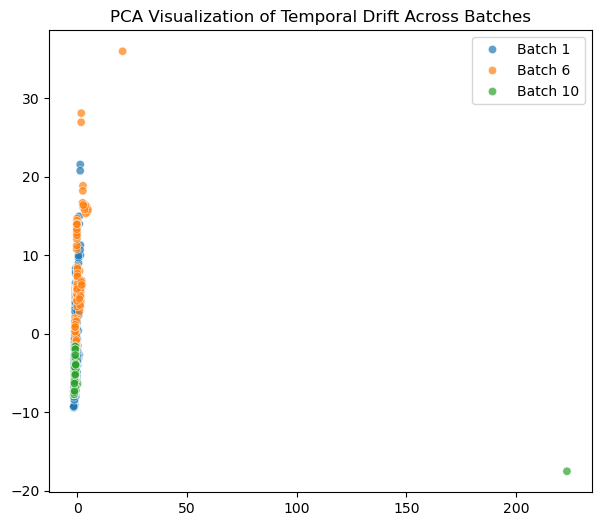

In [10]:
def safe_sample(df, n):
    return df.sample(min(len(df), n), random_state=42)

sample_1 = safe_sample(clean_batches[0], 200)
sample_6 = safe_sample(clean_batches[5], 200)
sample_10 = safe_sample(clean_batches[9], 200)

combined = pd.concat([sample_1, sample_6, sample_10], ignore_index=True)

X_comb = scaler.transform(combined.drop(["gas_type","concentration"], axis=1))

pca = PCA(n_components=2)
proj = pca.fit_transform(X_comb)

labels = (["Batch 1"] * len(sample_1) +
          ["Batch 6"] * len(sample_6) +
          ["Batch 10"] * len(sample_10))

plt.figure(figsize=(7,6))
sns.scatterplot(x=proj[:,0], y=proj[:,1], hue=labels, alpha=0.7)
plt.title("PCA Visualization of Temporal Drift Across Batches")
plt.show()

This visualization compares early, mid, and late batches to illustrate temporal drift in sensor feature space.

### 6.2 Feature Importance Drift Between Early and Late Batches

<Figure size 1000x500 with 0 Axes>

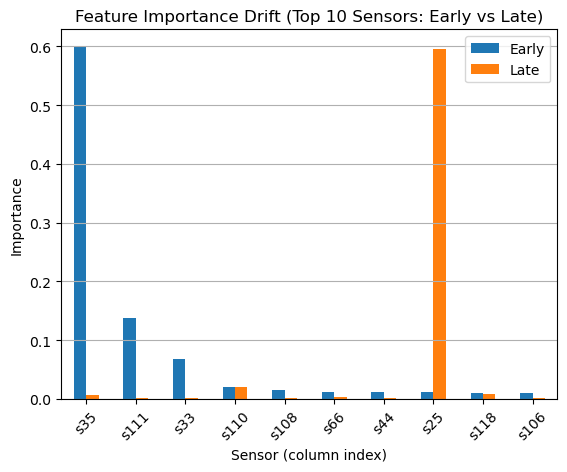

In [11]:
early_df = pd.concat(clean_batches[0:3], ignore_index=True)
X_early = early_df.drop(["gas_type", "concentration"], axis=1)
y_early = early_df["concentration"]

late_df = pd.concat(clean_batches[7:10], ignore_index=True)
X_late = late_df.drop(["gas_type", "concentration"], axis=1)
y_late = late_df["concentration"]

rf_early = RandomForestRegressor(n_estimators=150, random_state=42)
rf_late  = RandomForestRegressor(n_estimators=150, random_state=42)

rf_early.fit(X_early, y_early)
rf_late.fit(X_late, y_late)

imp_early = pd.Series(rf_early.feature_importances_, index=X_early.columns)
imp_late  = pd.Series(rf_late.feature_importances_, index=X_late.columns)

top_features = imp_early.sort_values(ascending=False).head(10).index

imp_compare = pd.DataFrame({
    "Early": imp_early[top_features],
    "Late":  imp_late[top_features]
}, index=top_features)

plt.figure(figsize=(10,5))
imp_compare.plot(kind="bar")
plt.title("Feature Importance Drift (Top 10 Sensors: Early vs Late)")
plt.ylabel("Importance")
plt.xlabel("Sensor (column index)")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

## 7. Baseline Drift Mitigation via Batch Normalization

In [12]:
def batch_normalize(df):
    features = df.drop(["gas_type","concentration"], axis=1)
    scaled = (features - features.mean()) / features.std()
    corrected = pd.concat([scaled, df[["gas_type", "concentration"]]], axis=1)
    return corrected

corrected_batches = [batch_normalize(df) for df in clean_batches]
train_corrected = pd.concat(corrected_batches[:6], ignore_index=True)
Xc = train_corrected.drop(["gas_type", "concentration"], axis=1)
yc = train_corrected["concentration"]

lin_corr = LinearRegression().fit(Xc, yc)
rf_corr = RandomForestRegressor(n_estimators=200, random_state=42).fit(Xc, yc)

In [13]:
results_corr = []
for i, batch in enumerate(corrected_batches[6:], start=7):
    Xb = batch.drop(["gas_type","concentration"], axis=1)
    yb = batch["concentration"]

    preds_lin = lin_corr.predict(Xb)
    preds_rf = rf_corr.predict(Xb)

    results_corr.append([
        i,
        np.sqrt(mean_squared_error(yb, preds_lin)),
        mean_absolute_error(yb, preds_lin),
        np.sqrt(mean_squared_error(yb, preds_rf)),
        mean_absolute_error(yb, preds_rf)
    ])

pd.DataFrame(results_corr, columns=[
    "Batch", "LR_RMSE_Corr", "LR_MAE_Corr",
    "RF_RMSE_Corr", "RF_MAE_Corr"
])


,Batch,LR_RMSE_Corr,LR_MAE_Corr,RF_RMSE_Corr,RF_MAE_Corr
0,7,167.044526,134.543705,136.592421,104.552503
1,8,177.428925,137.205992,103.908071,65.479705
2,9,259.028992,152.292819,140.146892,115.288002
3,10,812.213670,369.373217,195.295764,155.605404


## 8. Calibration-Based Model Adaptation

### 8.1 Fixed-Fraction Calibration (20%)

In [14]:
def eval_with_calibration(pred_batches, base_rf, X_train_scaled, y_train, scaler,
                          calib_fraction=0.2):
    rows = []

    for b_idx, batch in enumerate(pred_batches, start=7):
        calib = batch.sample(frac=calib_fraction, random_state=42)
        test = batch.drop(calib.index)

        X_calib = scaler.transform(calib.drop(["gas_type", "concentration"], axis=1))
        y_calib = calib["concentration"].values

        X_test = scaler.transform(test.drop(["gas_type", "concentration"], axis=1))
        y_test = test["concentration"].values

        y_pred_base = base_rf.predict(X_test)
        rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
        mae_base = mean_absolute_error(y_test, y_pred_base)
        r2_base = r2_score(y_test, y_pred_base)

        rf_adapt = deepcopy(base_rf)
        X_aug = np.vstack([X_train_scaled, X_calib])
        y_aug = np.concatenate([y_train.values, y_calib])
        rf_adapt.fit(X_aug, y_aug)

        y_pred_adapt = rf_adapt.predict(X_test)
        rmse_adapt = np.sqrt(mean_squared_error(y_test, y_pred_adapt))
        mae_adapt = mean_absolute_error(y_test, y_pred_adapt)
        r2_adapt = r2_score(y_test, y_pred_adapt)

        rows.append([
            b_idx,
            rmse_base, mae_base, r2_base,
            rmse_adapt, mae_adapt, r2_adapt
        ])

    cols = [
        "Batch",
        "RMSE_Base", "MAE_Base", "R2_Base",
        "RMSE_Adapt", "MAE_Adapt", "R2_Adapt"
    ]
    return pd.DataFrame(rows, columns=cols)

rf_calib_results = eval_with_calibration(
    prediction_batches, rf, X_train_scaled, y_train, scaler, calib_fraction=0.2
)
rf_calib_results

,Batch,RMSE_Base,MAE_Base,R2_Base,RMSE_Adapt,MAE_Adapt,R2_Adapt
0,7,61.990418,50.280586,0.205151,15.160763,6.104336,0.952458
1,8,65.850280,51.749645,0.349761,31.825535,15.242026,0.848117
2,9,79.597513,70.985277,-0.770856,45.092864,29.735894,0.431671
3,10,83.005938,75.294182,-1.856321,27.574826,12.863763,0.684780


In [15]:
xgb_calib_results = eval_with_calibration(
    prediction_batches, xgb_model, X_train_scaled, y_train, scaler, calib_fraction=0.2
)
xgb_calib_results

,Batch,RMSE_Base,MAE_Base,R2_Base,RMSE_Adapt,MAE_Adapt,R2_Adapt
0,7,36.893500,27.747630,0.718463,15.083357,7.268733,0.952942
1,8,60.673853,44.372760,0.447972,31.805199,16.054996,0.848311
2,9,71.345688,62.210238,-0.422721,38.644451,21.864161,0.582594
3,10,64.786103,57.841722,-0.740013,23.430473,12.235670,0.772411


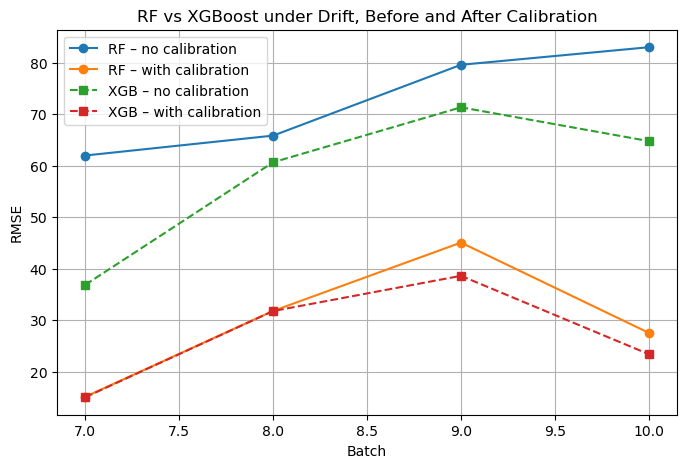

In [16]:
plt.figure(figsize=(8,5))

plt.plot(rf_calib_results["Batch"], rf_calib_results["RMSE_Base"],
         marker="o", label="RF – no calibration")
plt.plot(rf_calib_results["Batch"], rf_calib_results["RMSE_Adapt"],
         marker="o", label="RF – with calibration")

plt.plot(xgb_calib_results["Batch"], xgb_calib_results["RMSE_Base"],
         marker="s", linestyle="--", label="XGB – no calibration")
plt.plot(xgb_calib_results["Batch"], xgb_calib_results["RMSE_Adapt"],
         marker="s", linestyle="--", label="XGB – with calibration")

plt.xlabel("Batch")
plt.ylabel("RMSE")
plt.title("RF vs XGBoost under Drift, Before and After Calibration")
plt.legend()
plt.grid(True)
plt.show()

### 8.2 Residual Diagnostics: Batch 10

In [17]:
batch10 = prediction_batches[3]

calib10 = batch10.sample(frac=0.2, random_state=42)
test10  = batch10.drop(calib10.index)

X_calib10 = scaler.transform(calib10.drop(["gas_type", "concentration"], axis=1))
y_calib10 = calib10["concentration"].values

X_test10 = scaler.transform(test10.drop(["gas_type", "concentration"], axis=1))
y_test10 = test10["concentration"].values

# 1) Base RF (no calibration)
y_pred_base = rf.predict(X_test10)
resid_base = y_test10 - y_pred_base

# 2) Adapted RF (retrained with calibration on Batch 10)
rf_adapt10 = deepcopy(rf)
X_aug10 = np.vstack([X_train_scaled, X_calib10])
y_aug10 = np.concatenate([y_train.values, y_calib10])
rf_adapt10.fit(X_aug10, y_aug10)

y_pred_adapt = rf_adapt10.predict(X_test10)
resid_adapt = y_test10 - y_pred_adapt

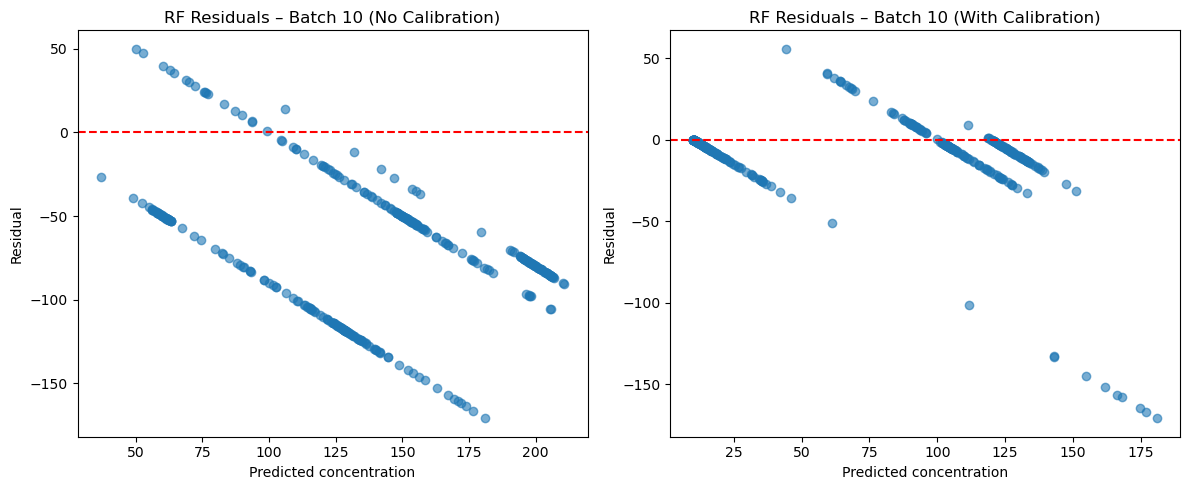

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_pred_base, resid_base, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("RF Residuals – Batch 10 (No Calibration)")
plt.xlabel("Predicted concentration")
plt.ylabel("Residual")

plt.subplot(1,2,2)
plt.scatter(y_pred_adapt, resid_adapt, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("RF Residuals – Batch 10 (With Calibration)")
plt.xlabel("Predicted concentration")
plt.ylabel("Residual")

plt.tight_layout()
plt.show()

## 9. Effect of Calibration Size on Drift Recovery

In [19]:
target_batch = 10                  
calib_fractions = [0.05, 0.10, 0.20, 0.30]
target_col = "concentration"

results = []

batch_df = prediction_batches[target_batch - 7].copy()

X_batch = batch_df.drop(["gas_type", "concentration"], axis=1)
y_batch = batch_df[target_col].values

X_batch_scaled = scaler.transform(X_batch)

y_pred_base = xgb_model.predict(X_batch_scaled)
rmse_base = np.sqrt(mean_squared_error(y_batch, y_pred_base))

results.append({
    "Calibration Fraction": 0.0,
    "Calibration Samples": 0,
    "RMSE": rmse_base
})

for frac in calib_fractions:
    n_calib = int(len(X_batch_scaled) * frac)

    X_calib = X_batch_scaled[:n_calib]
    y_calib = y_batch[:n_calib]

    X_eval = X_batch_scaled[n_calib:]
    y_eval = y_batch[n_calib:]

    model_calib = xgb.XGBRegressor(**xgb_model.get_params())
    model_calib.fit(X_calib, y_calib)

    y_pred = model_calib.predict(X_eval)
    rmse = np.sqrt(mean_squared_error(y_eval, y_pred))

    results.append({
        "Calibration Fraction": frac,
        "Calibration Samples": n_calib,
        "RMSE": rmse
    })

In [26]:
calib_size_df = pd.DataFrame(results)

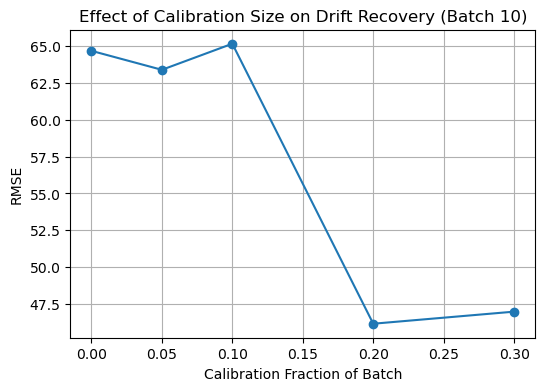

In [28]:
plt.figure(figsize=(6,4))
plt.plot(
    calib_size_df["Calibration Fraction"],
    calib_size_df["RMSE"],
    marker="o"
)
plt.xlabel("Calibration Fraction of Batch")
plt.ylabel("RMSE")
plt.title(f"Effect of Calibration Size on Drift Recovery (Batch {target_batch})")
plt.grid(True)
plt.show()